In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import string
import math
import matplotlib.patches as mpatches

In [2]:
corr = pd.read_csv("../temporal_country_models/model_results/coalgas_model_indep_correlation.csv", index_col=0)
corr = corr.round(2)

In [3]:
corr.columns

Index(['R_Choice', 'num_supply_policy', 'WDI_Coal_El_.', 'WDI_NG_El_.',
       'Share_VRE_Gen', 'Coal_logCurrent_MW', 'Gas_logCurrent_MW',
       'LogBP_GasR2P_yr', 'HHI_Coal_Import', 'HHI_Gas_Import',
       'NetValue_Coal_Import', 'NetValue_Gas_Import'],
      dtype='object')

In [4]:
def organize_reg_table(file_name):
    reg_table = pd.read_html(file_name)[0]
    col_num = 5
    #reg_table = reg_table.loc[6:,:]
    
    reg_table_names = reg_table[reg_table[0].isin(['Constant','Observations', 'R2', 'Adjusted R2', 'Akaike Inf. Crit.', 'Note:'])==False]
    variables = reg_table_names[0].dropna().unique()
    data_table = pd.DataFrame(data={"var":variables})
    data_table = data_table.set_index("var")
    n = 0
    for var in variables:
        var_ind = reg_table[reg_table[0]==var].index
        coef = reg_table.loc[var_ind,col_num].iloc[0]
        if isinstance(coef, str):
            sig = coef.count('*')
            data_table.loc[var,"coef"] = float(reg_table.loc[var_ind,col_num].iloc[0].replace("*",""))
            data_table.loc[var,"error"] = float(reg_table.loc[var_ind+1,col_num].iloc[0][1:-1])
            data_table.loc[var,"sig"] = sig*"*"
            data_table.loc[var,"upper_alphabet"] = string.ascii_uppercase[n]

            if var in ["Log GDP per capita"]:
                data_table.loc[var,"type"] = "development"
                data_table.loc[var,"color"] = "blue"
            elif var in ['Coal share in electricity', 'Gas share in electricity', 'VRE share in electricity',
                         'Years since first coal plant', 
                         'Years since first gas plant','Log current coal capacity', 'Log current gas capacity']:
                data_table.loc[var,"type"] = "incumbent technologies"
                data_table.loc[var,"color"] = "dodgerblue"
            elif var in ['Log gas reserve production ratio']:
                data_table.loc[var,"type"] = "resource availability"
                data_table.loc[var,"color"] = "orange"
            elif var in ['Coal import trade diversity', 'Gas import trade diversity', 'Coal net import value',
               'Gas net import value']:
                data_table.loc[var,"type"] = "trade dynamics"
                data_table.loc[var,"color"] = "olive"
            elif var in ['Number of energy supply policies', 'Air quality standards','Annex I','Annex II',"Choice of supplier"]:
                data_table.loc[var,"type"] = "policy"
                data_table.loc[var,"color"] = "violet"
            n=n+1
            
    r2 = reg_table[reg_table[0]=='R2'][col_num].iloc[0]
    obs = reg_table[reg_table[0]=='Observations'][col_num].iloc[0]

    data_table = data_table.dropna()
    data_table["var_name"] = corr.columns
    data_table.index = data_table.index.str.replace('Number of','#')
    data_table["print_name"] = data_table["upper_alphabet"] + " | " + data_table.index
    data_table = data_table[::-1]
    return [data_table, r2, obs]

In [5]:
coal_gen_table = organize_reg_table("../temporal_country_models/model_results/Coal_Gen_Decline_Perc.html")
coal_cap_table = organize_reg_table("../temporal_country_models/model_results/Coal_Share_PhasedOut.html")
gas_gen_table = organize_reg_table("../temporal_country_models/model_results/Gas_Gen_Decline_Perc.html")

### visualization

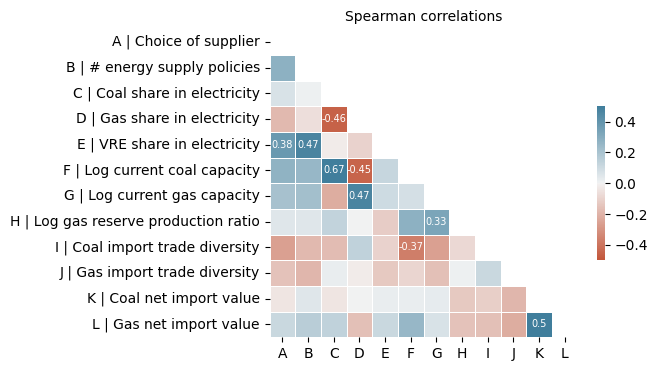

In [6]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, axes = plt.subplots(figsize=(5,4))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5,linewidths=.5,ax=axes,
           cbar_kws={"location":"right","shrink":0.5},square=True)
#cbar = plt.cm.ScalarMappable(cmap=cmap)
#cb = plt.colorbar(cbar, cax=axes[0,0],extend='both',orientation='horizontal')
sns.heatmap(corr.mask((corr < 0.30)|(corr ==1)), mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5,
            linewidths=.5,ax=axes, cbar=None, annot=True,annot_kws={"fontsize":7},fmt='.3g')
sns.heatmap(corr.mask(corr > -0.3), mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5,
            linewidths=.5,ax=axes, cbar=None, annot=True,annot_kws={"fontsize":7},fmt='.3g')
#for i in np.arange(len(corr)-1):
#    axes[3].axhline(i+1.5,color="lightgray",linestyle=":",zorder=-1)
#axes[3].set_yticklabels([])
#axes[3].tick_params(left = False)
axes.set_yticklabels(coal_gen_table[0]["print_name"][::-1], rotation=0)
axes.set_xticklabels(coal_gen_table[0]["upper_alphabet"][::-1], rotation=0)
axes.set_title("Spearman correlations",fontsize=10)
f.savefig("Fig3_correlations.png",dpi=600, bbox_inches='tight')
f.savefig("Fig3_correlations.pdf", bbox_inches='tight')

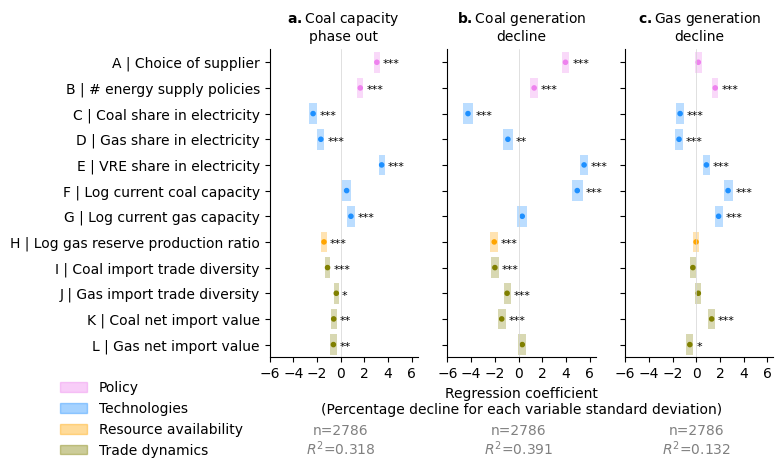

In [7]:
f, axes = plt.subplots(1,3,figsize=(6.5,4))
reg_results = [coal_cap_table,coal_gen_table,gas_gen_table]
reg_names = [r"$\bf{a. }$"+"Coal capacity\nphase out",r"$\bf{b. }$"+"Coal generation\ndecline",r"$\bf{c. }$"+"Gas generation\ndecline"]
n = 0
for ind_reg_result in reg_results:
    data_table = ind_reg_result[0]
    axes[n].set_facecolor("white")#'#EBEBEB')
    #axes[n].grid(which='major', color='white', linewidth=1.2)
    #[axes[n].spines[side].set_visible(False) for side in axes[n].spines]
    axes[n].spines['top'].set_visible(False)
    axes[n].spines['right'].set_visible(False)
    #axes[n].errorbar(data_table["coef"], data_table.index, xerr=data_table["error"], fmt=".")
    axes[n].barh(data_table["print_name"], left=list(data_table["coef"]-data_table["error"]),width=(data_table["error"]*2),
                  color=data_table["color"],alpha=0.3,zorder=2)
    axes[n].scatter(data_table["coef"], data_table["print_name"], color=data_table["color"],marker=".",zorder=2)
    axes[n].axvline(0,color="lightgray",linewidth=0.5)
    
    if n!=0:
        axes[n].set_yticklabels([])
    
    axes[n].set_ylim([-0.5,len(data_table)-0.5])
    axes[n].set_title(reg_names[n],fontsize=10)

    axes[n].set_xlim([-6,6.5])
    axes[n].set_xticks([-6,-4,-2,0,2,4,6])
    for i in np.arange(len(data_table["sig"])):
        axes[n].text(data_table[["coef","error"]].sum(axis=1)[i]+0.25,i-0.2,data_table["sig"][i], horizontalalignment='left',fontsize=8,color="black",zorder=2)
    axes[n].text(0,-3.5,"n="+ind_reg_result[2],ha='center',color="gray")
    axes[n].text(0,-4.3,"$R^{2}$="+ind_reg_result[1],ha='center',color="gray")
    n = n +1

plt.legend(handles=[mpatches.Patch(color="violet",alpha=0.4, label='Policy'),
                   mpatches.Patch(color="dodgerblue",alpha=0.4, label='Technologies'),
                   mpatches.Patch(color="orange",alpha=0.4, label='Resource availability'),
                   mpatches.Patch(color="olive",alpha=0.4, label='Trade dynamics')],
          loc='center', bbox_to_anchor=(-3.2, -0.2),frameon=False)

axes[1].set_xlabel("Regression coefficient\n(Percentage decline for each variable standard deviation)")
f.savefig("Fig4_model.png",dpi=600, bbox_inches='tight')
f.savefig("Fig4_model.pdf", bbox_inches='tight')